# K-Means Clustering from Scratch
***
## Table of Contents
1. Load Data
***

K-Means Clustering is an unsupervised algorithm that partitions the data into $K$ clusters, minimising the within-cluster variance.

1. Initialise centroids: Randomly choose $K$ points as initial cluster centroids.
2. Assign labels: Assign each point to the closest centroid.
3. Update centroids: Recalculate centroids as the mean of all points in each cluster.
4. Iterate: Repeat 2 & 3 until convergence occurs (e.g., centroids stop changing significantly).

In [749]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from numpy.typing import NDArray

## 1. Load Data

In [750]:
iris = load_iris()
X = iris.data

df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['species'] = iris.target

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


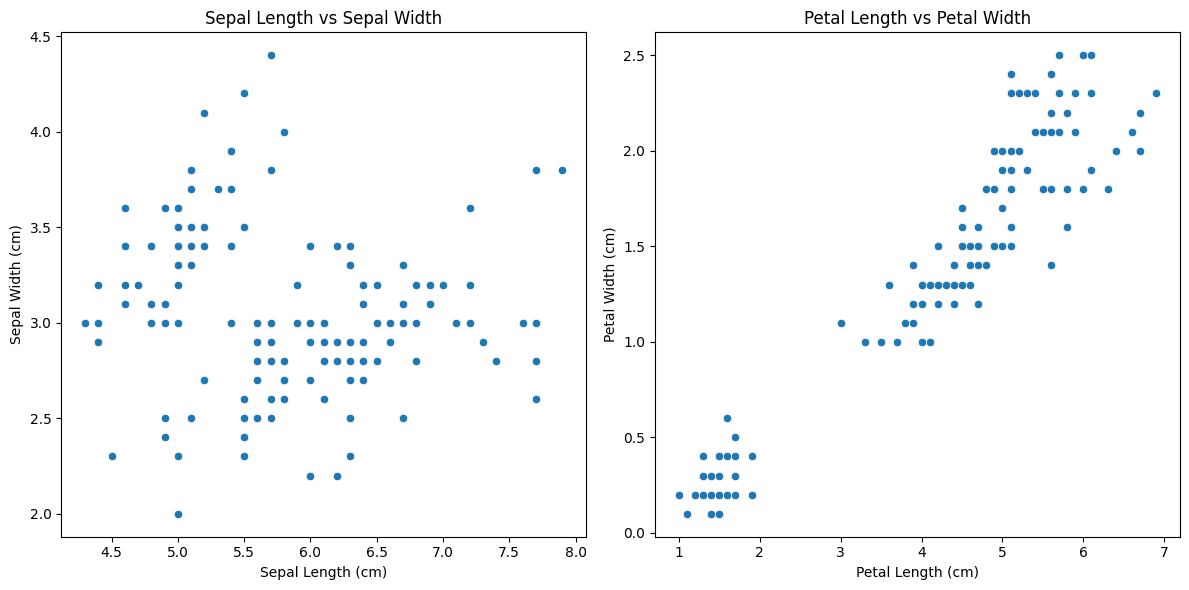

In [751]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
for i, feature in enumerate(['sepal', 'petal']):
    sns.scatterplot(
        ax=axes[i], data=df, x=f'{feature} length (cm)', y=f'{feature} width (cm)')
    axes[i].set_title(
        f'{str.title(feature)} Length vs {str.title(feature)} Width')
    axes[i].set_xlabel(f'{str.title(feature)} Length (cm)')
    axes[i].set_ylabel(f'{str.title(feature)} Width (cm)')
plt.tight_layout()
plt.show()

## 2. Initialise Centroids
First, we randamly choose k points from the dataset X for initial centroids.

In [752]:
def initialise_centroids(X: NDArray, k: int, random_seed: int = 42) -> NDArray:
    """
    Randomly selects k points from X to serve as initial centroids.

    Parameters:
    - X (NDArray): NDArrayof shape (n_samples, n_features)
    - k (int): number of clusters

    Returns:
    - centroids (NDArray): NDArrayof shape (k, n_features)
    """
    np.random.seed(random_seed)  # For reproducibility
    random_indices = np.random.choice(len(X), size=k, replace=False)
    return X[random_indices]

## 3. Distance Metric
Euclidean distance (L2 norm) is the standard metric for K-Means. It measures straight-line distance between all points and centroids.


In [753]:
def calculate_euclidean(points: NDArray, centroid: NDArray) -> NDArray:
    """
    Computes Euclidean distance between a batch of points and a centroid.

    Parameters:
    - points (NDArray): NDArray of shape (n_samples, n_features)
    - centroid (NDArray): NDArray of shape (n_features,)

    Returns:
    - distances (NDArray): Calculated euclidean distance from all points to centroids (n_samples,)
    """
    return np.sqrt(np.sum((points - centroid) ** 2, axis=1))

## 4. Assign Points
Each point gets labelled to its nearest centroid, effectively partitioning the dataset into convex regions.

In [754]:
def assign_clusters(X: NDArray, centroids: NDArray) -> NDArray:
    """
    Assigns each point in X to the closest centroid.

    Parameters:
    - X (NDArray): NDArray of shape (n_samples, n_features)
    - centroids (NDArray): NDArray of shape (k, n_features)

    Returns:
    - clusters (NDArray): NDArray of shape (n_samples,) with cluster labels (0 to k-1)
    """
    distances = np.array([calculate_euclidean(X, centroid)
                         for centroid in centroids])
    return np.argmin(distances, axis=0)

## 5. Update Centroids
After all points are labelled, we calculate the mean value of each cluster and assign new centroids. 

In [755]:
def update_centroids(X: NDArray, clusters: NDArray, k: int) -> NDArray:
    """
    Computes the new centroids as the mean of the points assigned to each cluster.

    Parameters:
    - X (NDArray): NDArray of shape (n_samples, n_features)
    - clusters (NDArray): NDArray of shape (n_samples,) with cluster labels
    - k (int): number of clusters

    Returns:
    - new_centroids (NDArray): NDArray of shape (k, n_features)
    """
    return np.array([X[clusters == i].mean(axis=0) for i in range(k)])

## 6. Check Convergence
To prevent unnecessary computations, we create a function with a tolerance parameter for early stopping.

In [756]:
def is_converged(old_centroids: NDArray, new_centroids: NDArray, tol: float = 1e-4) -> bool:
    """
    Checks if centroids have stopped changing significantly.

    Parameters:
    - old_centroids (NDArray): NDArrayof previous centroids
    - new_centroids (NDArray): NDArrayof updated centroids
    - tol (float): tolerance threshold for convergence

    Returns:
    - Boolean: True if ALL centroids converged
    """
    return np.all(np.linalg.norm(new_centroids - old_centroids, axis=1) < tol)

In [757]:
def kmeans_clustering(X, k, max_iters=100, tol=1e-4):
    centroids = initialise_centroids(X, k)
    history = [{'centroids': centroids.copy(), 'labels': None}]

    for i in range(max_iters):
        distances = np.array([calculate_euclidean(X, c) for c in centroids]).T
        labels = np.argmin(distances, axis=1)
        new_centroids = update_centroids(X, labels, k)

        history.append(
            {'centroids': new_centroids.copy(), 'labels': labels.copy()})

        if is_converged(centroids, new_centroids, tol):
            print(f"Converged after {i} iterations.")
            break

        centroids = new_centroids

    return labels, centroids, history

## 7. Encapsulation
Object-oriented implementation with some performance improvements.

In [758]:
class KMeans:
    """K-Means clustering implementation with vectorised operations."""

    def __init__(self, k: int, max_iters: int = 100, tol: float = 1e-4, random_seed: int = 42, disp_conv=False):
        self.k = k
        self.max_iters = max_iters
        self.tol = tol
        self.rng = np.random.default_rng(random_seed)  # Local generator
        self.centroids = None
        self.labels = None
        self.history = None
        self.disp_conv = disp_conv
        self.n_iter_ = 0  # Track actual iterations

    def _calculate_distances(self, X: NDArray, centroids: NDArray) -> NDArray:
        """Vectorised distance calculation using broadcasting."""
        return np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)

    def _initialise_centroids(self, X: NDArray) -> NDArray:
        """Improved initialisation with local RNG."""
        return self.rng.choice(X, size=self.k, replace=False, axis=0)

    def _update_centroids(self, X: NDArray, labels: NDArray) -> NDArray:
        """Handle empty clusters by keeping previous centroids."""
        new_centroids = np.empty_like(self.centroids)
        for i in range(self.k):
            cluster_points = X[labels == i]
            # Avoid failure when clusters become empty
            if len(cluster_points) > 0:
                new_centroids[i] = cluster_points.mean(axis=0)
            else:
                # Maintain previous position
                new_centroids[i] = self.centroids[i]
        return new_centroids

    def _is_converged(self, old: NDArray, new: NDArray) -> bool:
        return np.all(np.linalg.norm(new - old, axis=1) < self.tol)

    def fit(self, X: NDArray):
        """Fit with progress tracking and empty cluster handling."""
        self.centroids = self._initialise_centroids(X)
        self.history = [{'centroids': self.centroids.copy(), 'labels': None}]

        for self.n_iter_ in range(1, self.max_iters + 1):
            distances = self._calculate_distances(X, self.centroids)
            labels = np.argmin(distances, axis=1)
            new_centroids = self._update_centroids(X, labels)

            # Store both centroids AND labels at each iteration
            self.history.append({
                'centroids': new_centroids.copy(),
                'labels': labels.copy()
            })

            if self._is_converged(self.centroids, new_centroids):
                if self.disp_conv:
                    print(f"Converged after {self.n_iter_} iterations.")
                break

            self.centroids = new_centroids
        self.labels = labels
        return self

    def predict(self, X: NDArray) -> NDArray:
        """Vectorised prediction."""
        if self.centroids is None:
            raise ValueError("Model not fitted. Call fit() first.")
        return np.argmin(self._calculate_distances(X, self.centroids), axis=1)

## 8. Visualisation (Clusters)
Now, let's visualise the results. We will plot the clustered data along with the centroids to observe the final grouping. Additionally, we will show the progress of the KMeans algorithm at selected iterations, illustrating how the centroids and cluster assignments evolve over time. This helps us better understand the convergence process and the formation of clusters.

In [759]:
def plot_kmeans_clusters(df, features, clusters_list, centroids_list, palette):
    """
    Plot KMeans clustered data with centroids for given features.

    Parameters:
    - df: pandas DataFrame containing the data
    - features: list of strings, e.g. ['sepal', 'petal']
    - clusters_list: list of cluster arrays corresponding to each feature set
    - centroids_list: list of numpy arrays of centroids corresponding to each feature set
    - palette: seaborn colour palette (list of colours)
    """
    colors = palette.as_hex()
    fig, axes = plt.subplots(1, len(features), figsize=(6 * len(features), 6))

    # Handle single subplot case
    if len(features) == 1:
        axes = [axes]

    for i, feature in enumerate(features):
        clusters = clusters_list[i]
        centroids = centroids_list[i]

        # Get the appropriate columns for this feature set
        if i == 0:  # First plot (sepal)
            x_col, y_col = df.columns[0], df.columns[1]
        else:  # Second plot (petal)
            x_col, y_col = df.columns[2], df.columns[3]

        # Create scatter plot with cluster colours
        for cluster_id in range(len(centroids)):
            mask = clusters == cluster_id
            axes[i].scatter(df.loc[mask, x_col], df.loc[mask, y_col],
                            c=[colors[cluster_id]], s=60, alpha=0.7,
                            label=f'Cluster {cluster_id}')

        # Plot centroids
        for j, (x, y) in enumerate(centroids):
            axes[i].scatter(x, y, color=colors[j], marker='*', s=150,
                            edgecolor='black', linewidth=1.5,
                            label=f'Centroid {j}')

        axes[i].set_title(f'{feature.title()} Length vs Width (Clustered)')
        axes[i].set_xlabel(f'{feature.title()} Length (cm)')
        axes[i].set_ylabel(f'{feature.title()} Width (cm)')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

In [760]:
def plot_kmeans_transitions(X, history, title, palette, steps):
    colors = palette.as_hex()
    total_iters = len(history)
    indices = np.linspace(0, total_iters - 1, steps, dtype=int)

    fig, axes = plt.subplots(1, steps, figsize=(4 * steps, 5))

    for ax, idx in zip(axes, indices):
        data = history[idx]
        centroids = data['centroids']
        labels = data['labels']

        # When n_iter_ = 0 (before assigning points to clusters)
        if labels is None:
            ax.scatter(X[:, 0], X[:, 1], color='gray', s=40, alpha=0.6)

        # When n_iter_ > 0
        else:
            for j, color in enumerate(colors):
                points = X[labels == j]
                ax.scatter(points[:, 0], points[:, 1], color=color,
                           s=40, alpha=0.8, label=f'Cluster {j}')

        for j, (x, y) in enumerate(centroids):
            ax.scatter(x, y, color=colors[j], marker='*', s=150,
                       edgecolor='black', linewidth=1.5, label=f'Centroid {j}')

        ax.set_title(f'Iteration {idx}')
        ax.set_xlabel("Length (cm)")
        ax.set_ylabel("Width (cm)")
        ax.set_xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
        ax.set_ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)

    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

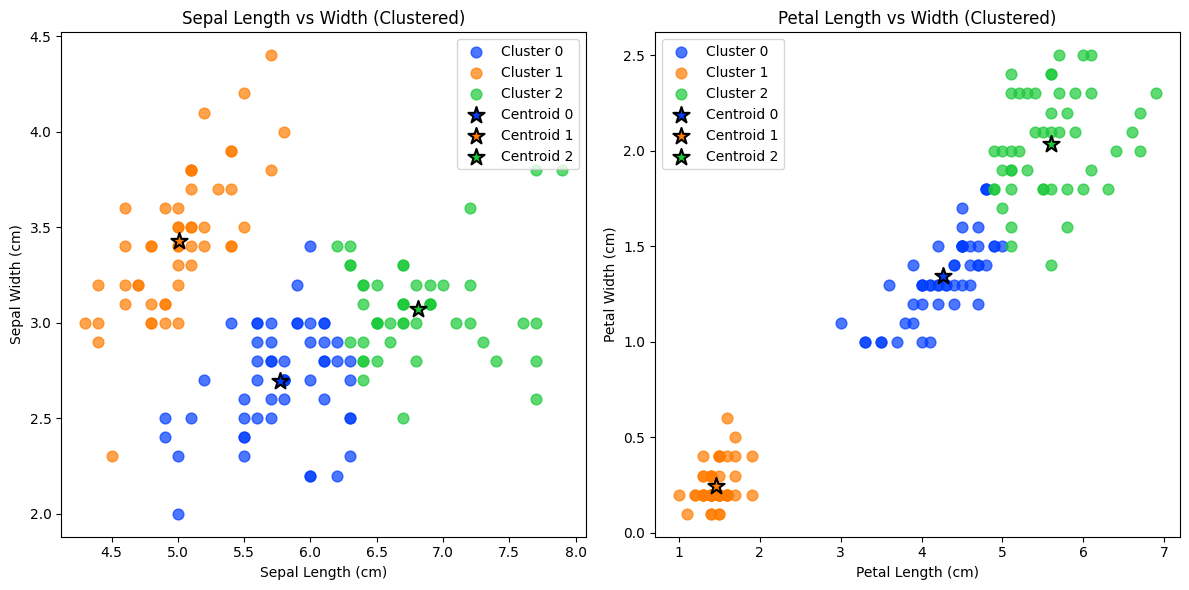

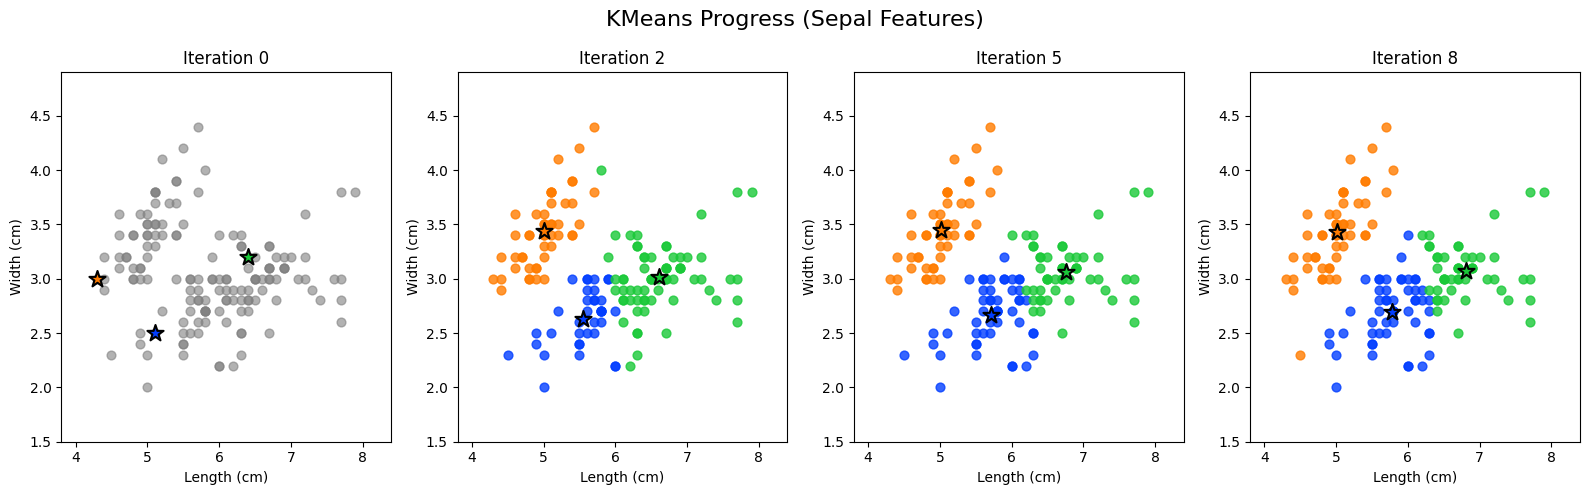

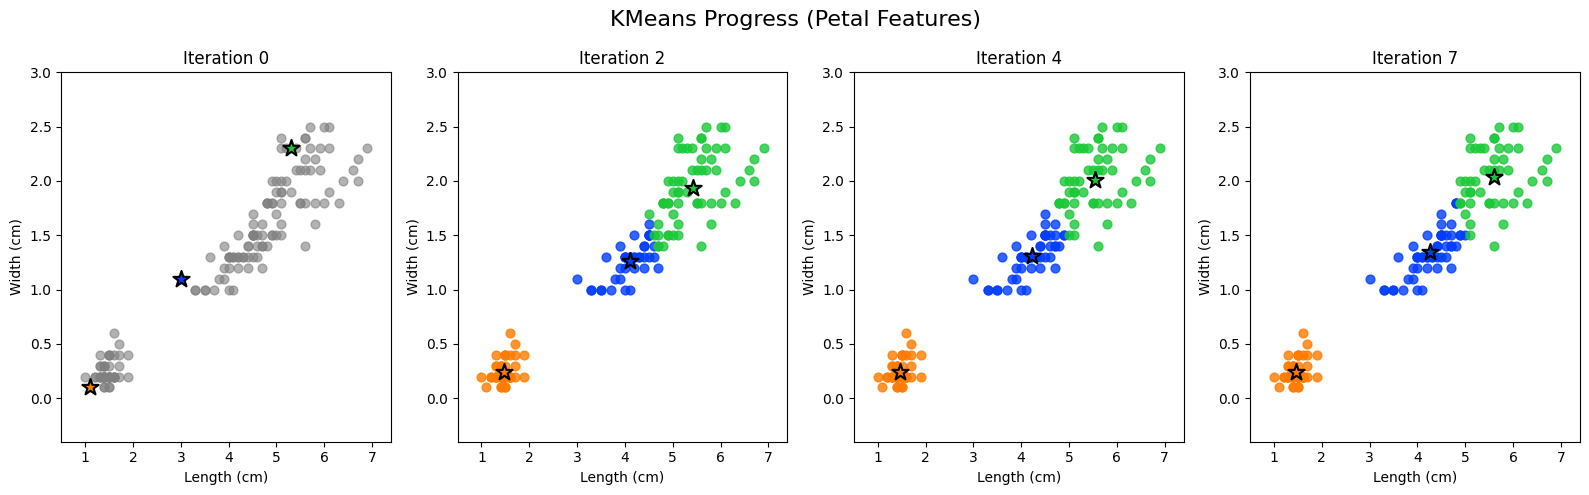

In [761]:
k = 3
random_seed = 42

# For sepal features
X_sepal = df.iloc[:, :2].values
kmeans_sepal = KMeans(k=k, random_seed=random_seed)
kmeans_sepal.fit(X_sepal)
clusters_sepal = kmeans_sepal.labels
centroids_sepal = kmeans_sepal.centroids
sepal_history = kmeans_sepal.history

# For petal features
X_petal = df.iloc[:, 2:4].values
kmeans_petal = KMeans(k=k, random_seed=random_seed)
kmeans_petal.fit(X_petal)
clusters_petal = kmeans_petal.labels
centroids_petal = kmeans_petal.centroids
petal_history = kmeans_petal.history

# Use with your plotting function
palette = sns.color_palette('bright', n_colors=k)
features = ['sepal', 'petal']
clusters_list = [clusters_sepal, clusters_petal]
centroids_list = [centroids_sepal, centroids_petal]

plot_kmeans_clusters(df, features, clusters_list, centroids_list, palette)

# Plot transitions for sepal
plot_kmeans_transitions(
    X_sepal, sepal_history, "KMeans Progress (Sepal Features)", palette, steps=4)

# Plot transitions for petal
plot_kmeans_transitions(
    X_petal, petal_history, "KMeans Progress (Petal Features)", palette, steps=4)

## 9. Evaluation Metrics
### Within-Cluster Sum of Squares (WCSS) / Inertia
The Within-Cluster Sum of Squares (WCSS), also known as **Inertia**, is the primary optimisation metric for K-Means algorithm. It measures the sum of squared distances between each point and its assigned centroid. Lower WCSS indicates better clustering quality, but is must be balanced against the number of clusters, typically using methods such as the elbow method.

\begin{align*}
\text{WCSS} = \sum_{k=1}^{K} \sum_{i=1}^{n} || x_i^{(k)} - \mu_k || ^2
\end{align*}

where:
- $K$: Total number of clusters.
- $x_i^{(k)}$: $i$-th data point that belongs to cluster $k$.
- $\mu_k$: Centroid (mean) of the $k$-th cluster.
- $n$: Total number of data points.

In [762]:
def calculate_wcss(X: NDArray, labels: NDArray, centroids: NDArray) -> float:
    """
    Calculate Within-Cluster Sum of Squares (WCSS)

    Parameters:
    - X (NDArray): data points of shape (n_samples, n_features)
    - labels (NDArray): cluster assignments of shape (n_samples,)
    - centroids (NDArray): cluster centers of shape (k, n_features)

    Returns:
    - wcss (float): within-cluster sum of squares
    """
    wcss = 0
    for i in range(len(centroids)):
        # Get all points assigned to cluster i
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            # Sum of squared distances from points to their centroid
            wcss += np.sum((cluster_points - centroids[i]) ** 2)
    return wcss

### Between-Cluster Sum of Squares (BCSS)
The Between-Cluster Sum of Squares (BCSS) quantifies how well the cluster centroids are separated by computing the distance between cluster centroids and the overall data mean. Higher BCSS indicates better separated clusters.

\begin{align*}
\text{BCSS} = \sum_{k=1}^{K} n_k|| \mu_k - \mu || ^2
\end{align*}

where:
- $K$: Total number of clusters.
- $n_k$: Number of data points in cluster $k$.
- $\mu_k$: Centroid (mean) of the $k$-th cluster.
- $\mu$: Overall mean of the entire dataset (global mean).

In [763]:
def calculate_bcss(X: NDArray, labels: NDArray, centroids: NDArray) -> float:
    """
    Calculate Between-Cluster Sum of Squares (BCSS).

    Parameters:
    - X (NDArray): data points of shape (n_samples, n_features)
    - labels (NDArray): cluster assignments of shape (n_samples,)
    - centroids (NDArray): cluster centers of shape (k, n_features)

    Returns:
    - bcss (float): between-cluster sum of squares
    """
    overall_mean = np.mean(X, axis=0)
    bcss = 0

    for i in range(len(centroids)):
        # Number of points in cluster i
        n_i = np.sum(labels == i)
        if n_i > 0:
            # Add weighted squared distance from centroid to overall mean
            bcss += n_i * np.sum((centroids[i] - overall_mean) ** 2)
    return bcss


### Total Sum of Squares (TSS)
The Total Sum of Squares (TSS) measures the total variance in the dataset. `TSS = WCSS + BCSS`.

\begin{align*}
\text{TSS} = \sum_{i=1}^{n} || x_i - \mu || ^2 = \text{WCSS} + \text{BCSS}
\end{align*}

where:
- $n$: Total number of data points.
- $x_i$ Data point
- $\mu$: Overall mean of the entire dataset (global mean).

In [764]:
def calculate_total_ss(X: NDArray) -> float:
    """
    Calculate Total Sum of Squares (TSS).

    Parameters:
    - X (NDArray): data points of shape (n_samples, n_features)

    Returns:
    - tss (float): total sum of squares
    """
    overall_mean = np.mean(X, axis=0)
    return np.sum((X - overall_mean) ** 2)

In [765]:
def evaluate(X: NDArray, labels: NDArray, centroids: NDArray):
    wcss = calculate_wcss(X, labels, centroids)
    bcss = calculate_bcss(X, labels, centroids)
    tss = calculate_total_ss(X)
    return wcss, bcss, tss

### Elbow Method
The Elbow Method is a technique used along with WCSS to identify the optimal number of clusters. The most intuitive way is to plot WCSS against different k values and look for the *elbow* point, where the rate of decrease in WCSS slows down significantly.

To measure the largest change in the rate of decrease, we take the second derivative of WCSS and then apply `.argmax` (the first derivative only tells the slope). 

In [766]:
def plot_elbow_curve(k_values: list, wcss_values: list) -> None:
    """
    Plot the elbow curve for determining optimal k.

    Parameters:
    - k_values (list): list of k values
    - wcss_values (list): corresponding WCSS values
    """
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, wcss_values, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True, alpha=0.3)

    # Highlight the potential elbow point
    if len(wcss_values) > 2:

        # Second derivative
        d_2 = np.diff(wcss_values, 2)

        # Elbow is at the index with maximum positive second derivative
        elbow_idx = np.argmax(d_2) + 2  # +2 because diff reduces length twice
        if elbow_idx < len(k_values):
            plt.axvline(x=k_values[elbow_idx], color='red', linestyle='--',
                        label=f'Potential Elbow at k={k_values[elbow_idx]}')
            plt.legend()
    plt.show()

## 10. Visualisation (Metrics)
We will visualise all the evaluation metrics above, and plot the elbow method for different `k` values ranging from 1 to 10.

In [767]:
def plot_evaluation_metrics(k_values:list, wcss_list:list, bcss_list:list, tss_list:list) -> None:
    """
    Plots WCSS, BCSS, and TSS metrics against the k values.

    Parameters:
        k_values (list): List of k values used for KMeans clustering.
        wcss_list (list): Within-Cluster Sum of Squares values.
        bcss_list (list): Between-Cluster Sum of Squares values.
        tss_list (list): Total Sum of Squares values.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 3 subplots in 1 row
    metrics_list = wcss_list, bcss_list, tss_list
    metrics_name = ['WCSS', 'BCSS', 'TSS']
    colors = ['blue', 'green', 'red']

    for i, (metric, name) in enumerate(zip(metrics_list, metrics_name)):
        axes[i].plot(k_values, metric, marker='o', label=name, color=colors[i])
        axes[i].set_title(f'{name} vs k')
        axes[i].set_xlabel('Number of Clusters (k)')
        axes[i].set_ylabel(name)
        axes[i].grid(True)
        axes[i].legend()
        
    plt.tight_layout()
    plt.show()

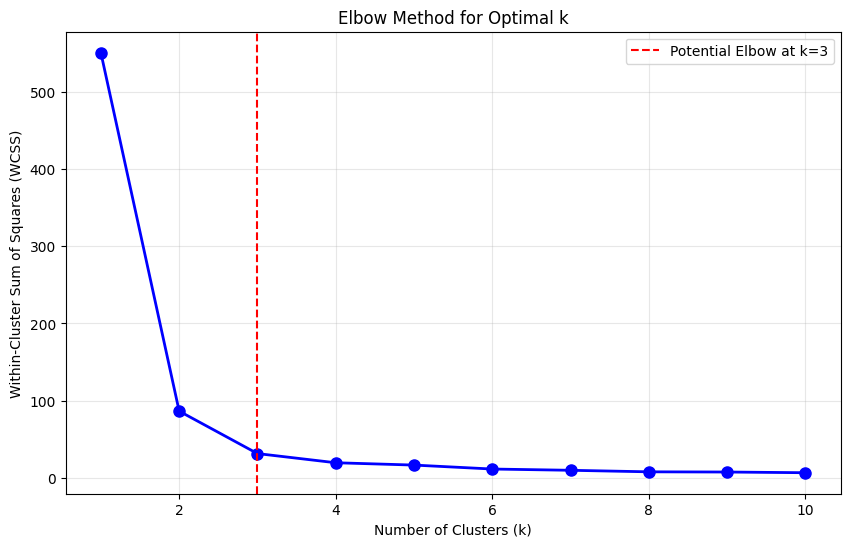

In [768]:
k_values = list(range(1, 11))  # `k` from 1 to 10
random_seed = 42
wcss_list = []
bcss_list = []
tss_list = []

# For sepal features
X_sepal = df.iloc[:, :2].values
for k in k_values:
    kmeans_sepal = KMeans(k=k, random_seed=random_seed, disp_conv=False)
    kmeans_sepal.fit(X_petal)
    clusters_sepal = kmeans_sepal.labels
    centroids_sepal = kmeans_sepal.centroids
    sepal_history = kmeans_sepal.history

    wcss, bcss, tss = evaluate(
        X=X_petal, labels=clusters_sepal, centroids=centroids_sepal)
    wcss_list.append(wcss)
    bcss_list.append(bcss)
    tss_list.append(tss)

plot_elbow_curve(k_values=k_values, wcss_values=wcss_list)

Our plot of the elbow method shows that the optimal value of `k` for this dataset is `3`.

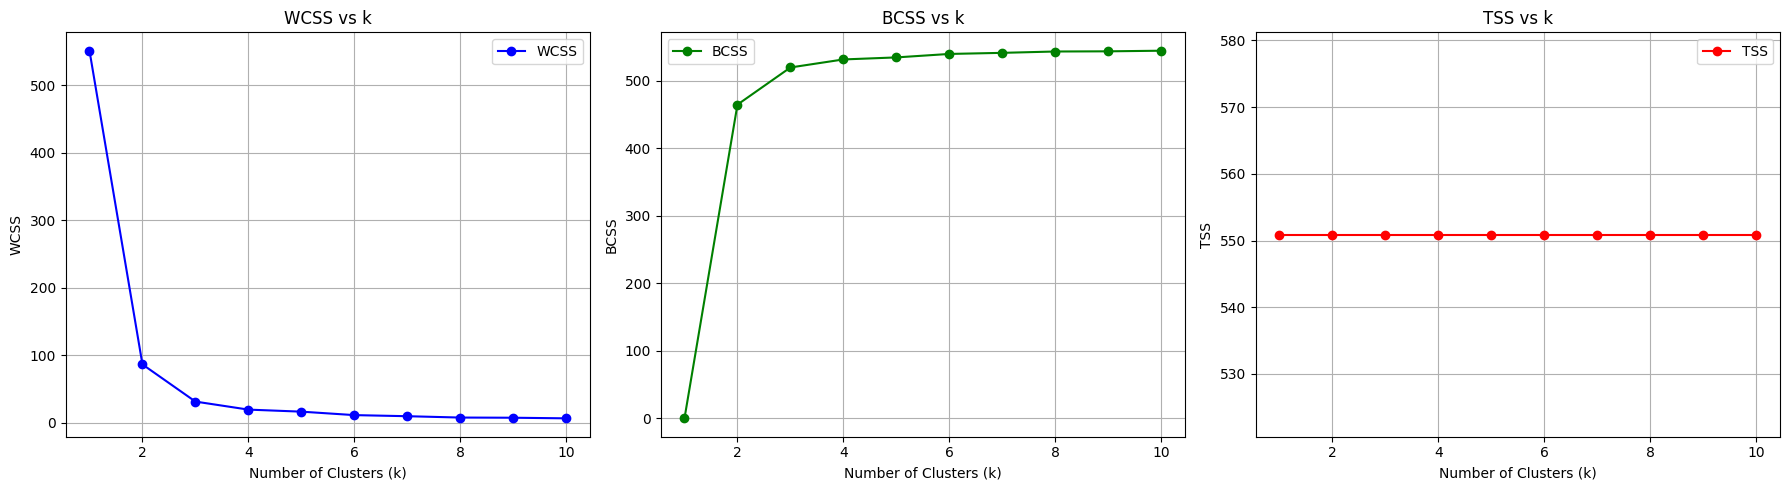

In [769]:
plot_evaluation_metrics(k_values, wcss_list, bcss_list, tss_list)

The error metrics demonstrate convergence as the number of clusters `k` increases, indicating that our implementation is working correctly.